# Inference using Borzoi

In this tutorial, we learn how to download a pre-trained model from the gReLU model zoo, use it for inference, visualize the results and interpret the model.

In [1]:
import numpy as np
import pandas as pd
import torch
import os

## Load the pre-trained Borzoi model from the model zoo

The grelu.resources module contains functions to access saved models and datasets associated with gReLU. grelu.resources.load_model is the function to load a saved model from the model zoo. 

We will load the Borzoi model (https://www.biorxiv.org/content/10.1101/2023.08.30.555582v1) trained to predict thousands of human genomic tracks from sequence.

Note that here we specify the model_name to be `human_rep0`. You can change human to mouse or change the replicate number to 1, 2, or 3 to access different versions of the Borzoi model.

In [2]:
import grelu.resources
model = grelu.resources.load_model(
    project="borzoi",
    model_name="human_rep0",
)

/usr/local/lib/python3.11/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
wandb: (1) Private W&B dashboard, no account required
wandb: (2) Use an existing W&B account


wandb: Enter your choice:  1


wandb: You chose 'Private W&B dashboard, no account required'
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: WARNING Serializing object of type list that is 351064 bytes
wandb: WARNING Serializing object of type list that is 351064 bytes
wandb: WARNING Serializing object of type list that is 351064 bytes
wandb: WARNING Serializing object of type list that is 351064 bytes
wandb: WARNING Serializing object of type list that is 351064 bytes
wandb: WARNING Serializing object of type list that is 351064 bytes
wandb: Downloading large artifact human_rep0:latest, 711.80MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:11.7


## View the model's metadata

`model.data_params` is a dictionary containing metadata about the data used to train the model. Let's look at what information is stored:

In [3]:
model.data_params.keys()

dict_keys(['tasks', 'train', 'val', 'test'])

Here, `tasks` is a large dictionary containing metadata about the output tracks that the model predicts. We can collect these into a dataframe:

In [4]:
tasks = pd.DataFrame(model.data_params['tasks'])
tasks.head(3)

,name,file,clip,clip_soft,scale,sum_stat,strand_pair,description,assay,sample
0,CNhs10608+,/home/drk/tillage/datasets/human/cage/fantom/C...,768,384,1.0,sum,1,CAGE:Clontech Human Universal Reference Total ...,CAGE,"Clontech Human Universal Reference Total RNA, ..."
1,CNhs10608-,/home/drk/tillage/datasets/human/cage/fantom/C...,768,384,1.0,sum,0,CAGE:Clontech Human Universal Reference Total ...,CAGE,"Clontech Human Universal Reference Total RNA, ..."
2,CNhs10610+,/home/drk/tillage/datasets/human/cage/fantom/C...,768,384,1.0,sum,3,CAGE:SABiosciences XpressRef Human Universal T...,CAGE,SABiosciences XpressRef Human Universal Total ...


Also, we have metadata related to the training data:

In [5]:
model.data_params['train'].keys()

dict_keys(['seq_len', 'label_len', 'genome', 'bin_size', 'intervals'])

In [6]:
for key in model.data_params['train'].keys():
    if key !="intervals":
        print(key, model.data_params['train'][key])

seq_len 524288
label_len 196608
genome hg38
bin_size 32


This tells us that the model was trained on sequences of length 524288 bp from the hg38 genome, and makes predictions for 196608 bp at 32 bp resolution.

You'll notice we left out `intervals`. This is a dictionary containing the intervals used for training, which we can extract into a dataframe:

In [7]:
pd.DataFrame(model.data_params['train']['intervals']).head()

,chrom,start,end
0,chr4,82360581,82884869
1,chr13,18440958,18965246
2,chr2,189759568,190283856
3,chr10,59711903,60236191
4,chr1,116945627,117469915


The genomic intervals used for validation and testing can also be extracted similarly.

## Make inference intervals

We will now use the model to make predictions on a specific genomic interval from chromosome 1. Since the model was trained on sequences of length 524288 bp, our input interval will be of the same length.

In [8]:
input_len = model.data_params["train"]["seq_len"]
chrom = "chr1"
input_start = 69993520
input_end = input_start + input_len

We format the interval(s) that we want to make predictions on as a dataframe containing columns "chrom", "start" and "end". A "strand" column can be supplied optionally.

In [9]:
input_intervals = pd.DataFrame({
    'chrom':[chrom], 'start':[input_start], 'end':[input_end], "strand":["+"],
})

input_intervals

,chrom,start,end,strand
0,chr1,69993520,70517808,+


## Extract the sequence

`grelu.sequence.format` contains functions to convert DNA sequences from one format to another. Here, we use it to convert the genomic interval into a string:

In [10]:
import grelu.sequence.format

input_seqs = grelu.sequence.format.convert_input_type(
    input_intervals,
    output_type="strings",
    genome="hg38"
)
input_seq = input_seqs[0]

len(input_seq)

17:45:41 | INFO | Downloading assembly summaries from GENCODE
17:46:14 | INFO | Downloading assembly summaries from UCSC
17:46:17 | INFO | Downloading assembly summaries from Ensembl
17:46:34 | INFO | Downloading genome from UCSC. Target URL: https://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz...
Download: 100%|███████████████████████████████████████████████████████████| 938M/938M [00:10<00:00, 93.8MB/s]
17:46:45 | INFO | Genome download successful, starting post processing...
17:47:05 | INFO | name: hg38
17:47:05 | INFO | local name: hg38
17:47:05 | INFO | fasta: /root/.local/share/genomes/hg38/hg38.fa
Filtering Fasta: 64.2M lines [00:24, 2.58M lines/s]


524288

This is a very long sequence - don't try to print the whole thing! Let's just look at the beginning.

In [11]:
input_seq[:10]

'ACTGTGCACC'

## Run inference on a single sequence

If we want to use the model to make a prediction on a single sequence or a few sequences, gReLU provides a very simple command to do this: `model.predict_on_seqs`. 

On the other hand, if we want to make batched predictions on many sequences, or average the predictions over different versions of the sequence, we should use gReLU's pytorch dataset classes. We'll see how to do that later.

In [15]:
%%time
preds = model.predict_on_seqs(input_seqs, device=0)
preds.shape

CPU times: user 4.11 s, sys: 67.6 ms, total: 4.17 s
Wall time: 1.36 s


(1, 7611, 6144)

Note the shape of `preds`: it's in the format `Batch, Tasks, Length`. So we have 1 sequence, 7611 tasks, and 6144 bins along the length axis.

## Get output interval coordinates

We know that the input was a 524288 bp region from chr1:69993520-70517808. But Borzoi is not making predictions for the entire region; it's cropping some positions from the sides. 

We can find out the region for which we are actually making predictions using the `input_intervals_to_output_intervals` method.

In [16]:
output_intervals = model.input_intervals_to_output_intervals(input_intervals)
output_intervals

,chrom,start,end,strand
0,chr1,70157360,70353968,+


In [17]:
output_start = output_intervals.start[0]
output_end = output_intervals.end[0]
output_len = output_end - output_start
print(output_len)

196608


We see that our predictions encompass the central 196608 bp of the input 524288 bp.

## Plot predictions

`grelu.visualize` provides a variety of functions to plot model predictions and performance. To start, we visualize the Borzoi predictions over the output region.

In [18]:
import grelu.visualize
%matplotlib inline

As an example, we will visualize the first 2 CAGE and RNA-seq output tracks for brain tissue.

In [19]:
cage_brain_tasks = tasks[(tasks.assay=="CAGE") & (tasks["sample"].str.contains("brain"))].head(2)
rna_brain_tasks = tasks[(tasks.assay=="RNA") & (tasks["sample"].str.contains("brain"))].head(2)

tasks_to_plot = cage_brain_tasks.index.tolist() + rna_brain_tasks.index.tolist()
task_names = tasks.description[tasks_to_plot].tolist() # Description of these tracks from the `tasks` dataframe

print(tasks_to_plot)
print(task_names)

[10, 11, 6635, 6636]
['CAGE:brain, adult, pool1', 'CAGE:brain, adult, pool1', 'RNA:brain tissue female adult (66 years)', 'RNA:brain tissue female adult (66 years)']


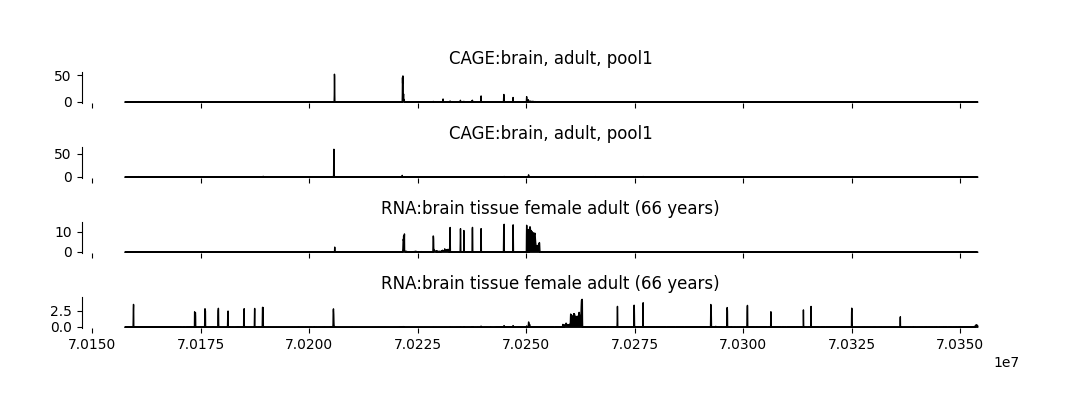

In [20]:
fig = grelu.visualize.plot_tracks(
    preds[0, tasks_to_plot, :], # Outputs to plot
    start_pos=output_start, # Start coordinate for the x-axis label
    end_pos=output_end, # End coordinate for the x-axis label
    titles=task_names, # titles for each track
    figsize=(10, 3.5), # width, height
)

## Add genomic annotations

We can also extract genomic annotations and visualize them alongside the predicted activity. Note that we use genomepy and you may need to install some UCSC tools to access the annotations. If you do not have these installed, you can use the commands below, or skip this section.

In [21]:
#!rsync -aP rsync://hgdownload.soe.ucsc.edu/genome/admin/exe/linux.x86_64/genePredToBed /usr/bin/
#!rsync -aP rsync://hgdownload.soe.ucsc.edu/genome/admin/exe/linux.x86_64/genePredToGtf /usr/bin/
#!rsync -aP rsync://hgdownload.soe.ucsc.edu/genome/admin/exe/linux.x86_64/bedToGenePred /usr/bin/
#!rsync -aP rsync://hgdownload.soe.ucsc.edu/genome/admin/exe/linux.x86_64/gtfToGenePred /usr/bin/
#!rsync -aP rsync://hgdownload.soe.ucsc.edu/genome/admin/exe/linux.x86_64/gff3ToGenePred /usr/bin/

receiving incremental file list
genePredToBed
     24,381,216 100%   54.97MB/s    0:00:00 (xfr#1, to-chk=0/1)
receiving incremental file list
genePredToGtf
     24,399,048 100%   73.40MB/s    0:00:00 (xfr#1, to-chk=0/1)
receiving incremental file list
bedToGenePred
     24,379,912 100%   79.08MB/s    0:00:00 (xfr#1, to-chk=0/1)
receiving incremental file list
gtfToGenePred
     24,385,272 100%   72.90MB/s    0:00:00 (xfr#1, to-chk=0/1)
receiving incremental file list
gff3ToGenePred
     24,480,328 100%   77.05MB/s    0:00:00 (xfr#1, to-chk=0/1)


Below, we will extract the coordinates for exons in the hg38 human genome:

In [21]:
import grelu.io.genome

exons = grelu.io.genome.read_gtf("hg38", features="exon")
exons.head(3)

17:49:16 | WARNING | Could not find 'hg38.annotation.bed(.gz)' in directory /root/.local/share/genomes/hg38. Methods using this file won't work!
17:49:16 | WARNING | Could not find 'hg38.annotation.gtf(.gz)' in directory /root/.local/share/genomes/hg38. Methods using this file won't work!
17:49:16 | INFO | Downloading the ncbiRefSeq annotation from the UCSC MySQL database.


Genome annotation files not found. Installing genome annotation files.


17:49:29 | INFO | Annotation download successful


,chrom,start,end,gene_name,source,feature,score,strand,frame,attribute
1,chr1,11874,12227,DDX11L1,genomepy,exon,.,+,.,"gene_id ""DDX11L1""; transcript_id ""NR_046018.2""..."
2,chr1,12613,12721,DDX11L1,genomepy,exon,.,+,.,"gene_id ""DDX11L1""; transcript_id ""NR_046018.2""..."
3,chr1,13221,14409,DDX11L1,genomepy,exon,.,+,.,"gene_id ""DDX11L1""; transcript_id ""NR_046018.2""..."


We filter those exons that overlap with the output region we are predicting:

In [22]:
import grelu.data.preprocess

output_exons = grelu.data.preprocess.filter_overlapping(
    exons,
    ref_intervals=output_intervals,
    method="any" # return the exon if there any overlap at all with the output interval. Set to 'all' for completely contained exons.
)
output_exons.head(3)

Keeping 560 intervals


,chrom,start,end,gene_name,source,feature,score,strand,frame,attribute
176820,chr1,70159330,70159438,LRRC40,genomepy,exon,.,-,.,"gene_id ""LRRC40""; transcript_id ""XM_047424520...."
176822,chr1,70173465,70173510,LRRC40,genomepy,exon,.,-,.,"gene_id ""LRRC40""; transcript_id ""XM_047424520...."
176824,chr1,70173622,70173709,LRRC40,genomepy,exon,.,-,.,"gene_id ""LRRC40""; transcript_id ""XM_047424520...."


This gives us all the exon coordinates in the output region. Since some of these exons may exceed the output region, we clip the start and end values to the output interval coordinates.

In [23]:
output_exons = grelu.data.preprocess.clip_intervals(output_exons, start=output_start, end=output_end)
output_exons.head(3)

,chrom,start,end,gene_name,source,feature,score,strand,frame,attribute
176820,chr1,70159330,70159438,LRRC40,genomepy,exon,.,-,.,"gene_id ""LRRC40""; transcript_id ""XM_047424520...."
176822,chr1,70173465,70173510,LRRC40,genomepy,exon,.,-,.,"gene_id ""LRRC40""; transcript_id ""XM_047424520...."
176824,chr1,70173622,70173709,LRRC40,genomepy,exon,.,-,.,"gene_id ""LRRC40""; transcript_id ""XM_047424520...."


We also want to annotate each gene, so we create a dataframe called genes that spans the region from the start of the first exon to the end of the last exon for each gene.

In [24]:
output_genes = grelu.data.preprocess.merge_intervals_by_column(
    output_exons, group_col="gene_name"
)
output_genes

,gene_name,chrom,start,end,strand
0,ANKRD13C,chr1,70258999,70336099,-
1,LRRC40,chr1,70159330,70205579,-
2,SRSF11,chr1,70205696,70253052,+


## Plot predictions with annotations

Now, we can add these annotations to the plot.

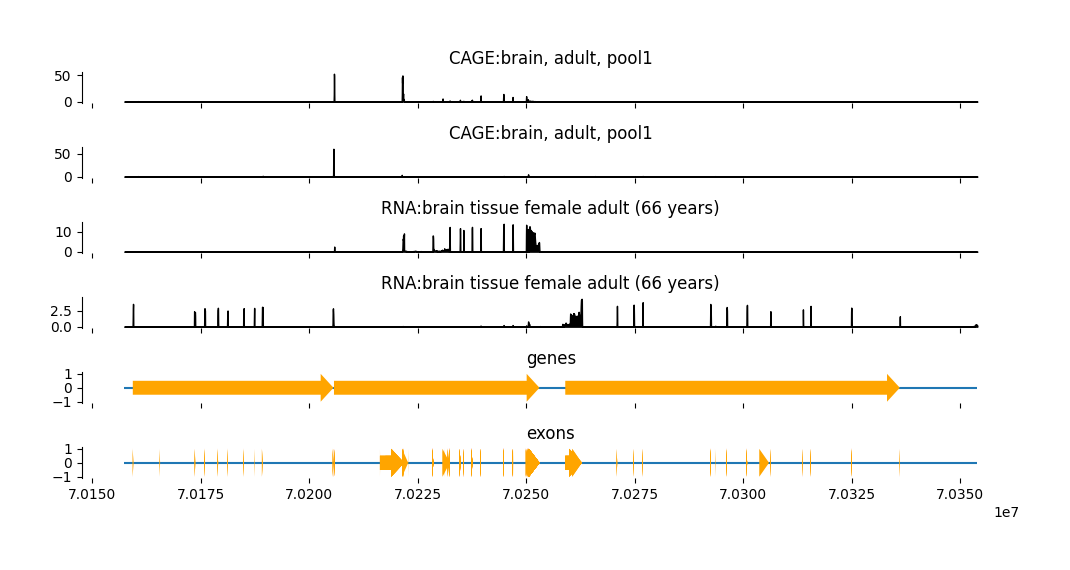

In [27]:
fig = grelu.visualize.plot_tracks(
    preds[0, tasks_to_plot, :], # Outputs to plot
    start_pos=output_start, # Start coordinate for x-axis
    end_pos=output_end, # End coordinate for x-axis
    titles=task_names,
    figsize=(10, 5),
    annotations={"genes":output_genes, "exons":output_exons} # Dictionary of annotation dataframes
)

## Analyze attention weights

Borzoi contains several transformer layers. Here, we can analyze the attention weights to see the relationships between local sequence regions. We use the `grelu.interpret.score` module which contains functions to score the importance of input bases.

In [28]:
import grelu.interpret.score

attn = grelu.interpret.score.get_attention_scores(
    model=model,
    seqs=input_seq, # You can also supply just the genomic interval
    genome='hg38',
    block_idx=-1, # We take attention weights from the final transformer layer
)

attn.shape

(8, 4096, 4096)

Note the shape of `attn`: It is in the form (heads, bins, bins). The first dimension is of length 8 since the transformer layer contains 8 heads. We will average the weights of all heads together to get a single bin x bin matrix.

In [29]:
attn = attn.mean(0)
attn.shape

(4096, 4096)

Before visualizing this matrix, let us once again collect the gene annotations. Since the attention matrix is obtained from the transformer layers before cropping, it corresponds to the 524 kb input interval, not the 196 kb output interval. So, we once again extract exons and genes, this time overlapping with the input interval.

In [30]:
input_exons = grelu.data.preprocess.filter_overlapping(
    exons,
    ref_intervals=input_intervals,
    method="any" # return the exon if there any overlap at all with the output interval. Set to 'all' for completely contained exons.
)
input_exons = grelu.data.preprocess.clip_intervals(input_exons, start=output_start, end=output_end)
input_genes = grelu.data.preprocess.merge_intervals_by_column(
    input_exons.iloc[:, :4], group_col="gene_name"
)
input_genes

Keeping 762 intervals


,gene_name,chrom,start,end
0,ANKRD13C,chr1,70258999,70353968
1,ANKRD13C-DT,chr1,70354811,70353968
2,CTH,chr1,70411268,70353968
3,LINC03102,chr1,70359559,70353968
4,LOC105378793,chr1,70449080,70353968
5,LRRC40,chr1,70157360,70205579
6,LRRC7,chr1,70157360,70144364
7,LRRC7-AS1,chr1,70157360,70042259
8,SRSF11,chr1,70205696,70253052


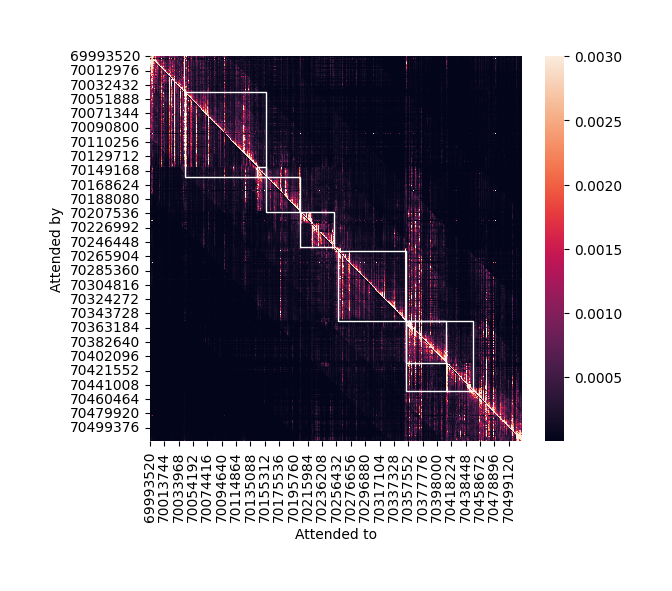

In [31]:
fig = grelu.visualize.plot_attention_matrix(
    attn,
    start_pos=input_start,
    end_pos=input_end,
    highlight_intervals=input_genes, # Draw a box around each gene
    vmax=0.003,
    figsize=(6,5)
)

## Calculate tissue specific expression over SRSF11 exons

Suppose we are interested in a specific function of the output - the total RNA-seq expression over all exons of the SRSF11 gene. Further, we are interested in the tissue specificity of this expression, in brain vs. liver. We first identify the relevant tasks in the model's predictions.

In [32]:
brain_tasks = tasks[(tasks.assay == "RNA") & (tasks["sample"].str.contains("brain"))].index.tolist()
print(brain_tasks)

[6635, 6636, 7539, 7540, 7541]


In [33]:
liver_tasks = tasks[(tasks.assay == "RNA") & (tasks["sample"].str.contains("liver"))].index.tolist()
print(liver_tasks)

[6132, 6133, 6146, 6147, 6437, 6438, 6490, 6491, 6579, 6580, 6582, 6583, 6691, 6692, 6730, 6731, 6770, 6916, 6917, 7181, 7182, 7563, 7564, 7565]


Let's look at what these tasks are:

In [34]:
tasks.iloc[brain_tasks].head(3)

,name,file,clip,clip_soft,scale,sum_stat,strand_pair,description,assay,sample
6635,ENCFF637ZBG+,/home/drk/tillage/datasets/human/rna/encode/EN...,768,384,0.30,sum_sqrt,6636,RNA:brain tissue female adult (66 years),RNA,brain tissue female adult (66 years)
6636,ENCFF637ZBG-,/home/drk/tillage/datasets/human/rna/encode/EN...,768,384,0.30,sum_sqrt,6635,RNA:brain tissue female adult (66 years),RNA,brain tissue female adult (66 years)
7539,GTEX-13FTY-0011-R11a-SM-5IJEA.1,/home/drk/tillage/datasets/human/rna/recount3/...,768,384,0.01,sum_sqrt,7539,RNA:brain,RNA,brain


In [35]:
tasks.iloc[liver_tasks].head(3)

,name,file,clip,clip_soft,scale,sum_stat,strand_pair,description,assay,sample
6132,ENCFF945UHI+,/home/drk/tillage/datasets/human/rna/encode/EN...,768,384,0.3,sum_sqrt,6133,RNA:liver tissue female child (6 years) and wi...,RNA,liver tissue female child (6 years) and with n...
6133,ENCFF945UHI-,/home/drk/tillage/datasets/human/rna/encode/EN...,768,384,0.3,sum_sqrt,6132,RNA:liver tissue female child (6 years) and wi...,RNA,liver tissue female child (6 years) and with n...
6146,ENCFF630VID+,/home/drk/tillage/datasets/human/rna/encode/EN...,768,384,0.3,sum_sqrt,6147,RNA:liver tissue female embryo (20 weeks) and ...,RNA,liver tissue female embryo (20 weeks) and male...


Now, let us get the coordinates of the exons of the SRSF11 gene.

In [36]:
srsf11_exons = exons[exons.gene_name == "SRSF11"]
srsf11_exons.head(3)

,chrom,start,end,gene_name,source,feature,score,strand,frame,attribute
176920,chr1,70205696,70205780,SRSF11,genomepy,exon,.,+,.,"gene_id ""SRSF11""; transcript_id ""XM_047434541...."
176921,chr1,70216294,70221839,SRSF11,genomepy,exon,.,+,.,"gene_id ""SRSF11""; transcript_id ""XM_047434541...."
176923,chr1,70228422,70228555,SRSF11,genomepy,exon,.,+,.,"gene_id ""SRSF11""; transcript_id ""XM_047434541...."


Remember that the model makes predictions for bins of width 32 bp. In order to get the predicted coverage over the SRSF11 exons, we need to identify the relevant bins in the output track that overlap with exons of SRSF11. We have another coordinate-conversion function for this:

In [37]:
srsf11_exon_bins = model.input_intervals_to_output_bins(
    intervals=srsf11_exons,
    start_pos=input_start # Start coordinate of the input sequence
)
srsf11_exon_bins.head(3)

,start,end
176920,1510,1514
176921,1841,2015
176923,2220,2225


We now have the indices of all the bins that overlap with each exon! Let's combine them:

In [38]:
selected_bins = set()
for row in srsf11_exon_bins.itertuples():
    selected_bins = selected_bins.union(list(range(row.start, row.end)))

selected_bins = list(selected_bins)

print(len(selected_bins))

380


Thus, out of the 6144 bins in the model's output, we are interested in only a subset of them. Now, we can use the `grelu.transforms` module to define a transform or objective function that calculates a specific score from the model's predictions.

We use the `Specificity` transform since we are computing the difference between on- and off- target tasks. To simply compute the mean or total prediction over specific regions/tasks, use the `Aggregate` transform.

In [39]:
import grelu.transforms.prediction_transforms

brain_specific_srsf11_score = grelu.transforms.prediction_transforms.Specificity(
    on_tasks = brain_tasks, # positive tasks
    off_tasks = liver_tasks, # negative tasks
    positions = selected_bins, # The relevant regions of the output
    on_aggfunc = "mean", # Average expression over the positive tasks
    off_aggfunc = "mean", # Average expression over the negative tasks
    length_aggfunc = "mean", # Average expression over the bins
    compare_func = "divide", # Return the ratio of expression in positive tasks to negative tasks
)

By applying this function to our model's predictions, we get the ratio between the mean expression in exons of SRSF11 in brain RNA-seq tracks vs. in liver RNA-seq tracks.

In [40]:
brain_specific_srsf11_score.compute(preds)

array([[[1.6088623]]], dtype=float32)

Thus, the total expression over all annotated SRSF11 exons is on average 1.6x higher in brain RNA-seq tracks.

## ISM with respect to specific expression

We can perform In Silico Mutagenesis (ISM) to identify which bases in the input sequence are contributing to the tissue-specific expression. Since ISM on all 524288 bases would take a long time, we will take 100 bases upstream and downstream of the start position of the first exon.

gReLU also offers other interpretation methods - see `grelu.interpret.score.get_attributions` to compute gradients instead of ISM.

In [41]:
ism_start_pos = srsf11_exons.start.min() - 100
ism_end_pos = srsf11_exons.start.min() + 100
print(ism_start_pos, ism_end_pos)

70205596 70205796


In [42]:
%%time

ism = grelu.interpret.score.ISM_predict(
    seqs=input_seq, # You can also supply genomic intervals
    model=model,
    prediction_transform=brain_specific_srsf11_score, # We will compute how each base affects this score
    devices=0, # Index of the GPU to use
    batch_size=8,
    num_workers=1,
    start_pos=ism_start_pos-input_start, # Relative start position from the first base
    end_pos=ism_end_pos-input_start, # Relative end position from the first base
    return_df=True, # Return a dataframe
    compare_func="log2FC", # Return the log2 ratio between the predictions for the mutated sequence and the reference sequence
)

ism.shape

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting DataLoader 0: 100%|█████████████████████████████████████████████| 100/100 [03:32<00:00,  0.47it/s]
CPU times: user 3min 33s, sys: 2.06 s, total: 3min 35s
Wall time: 3min 35s


(4, 200)

The output here is a dataframe with 4 rows corresponding to the bases that were substituted at each position (A, C, G and T) and 200 columns, one for each position that was mutated. Because we selected `compare_func="log2FC"`, the values in the dataframe represent log (score of mutated sequence / score of original sequence).

In [43]:
ism.iloc[:, :5]

,C,C,G,T,T
A,-0.000303,-0.001695,-0.000815,-0.002089,-0.001104
C,0.000000,0.000000,-0.002890,-0.002399,0.000142
G,-0.004893,-0.004773,0.000000,-0.002275,-0.002599
T,0.000046,0.000599,-0.004783,0.000000,0.000000


We can visualize these ISM scores in two ways: as a heatmap or as a sequence logo where the height of each base corresponds to its importance.

<Axes: >

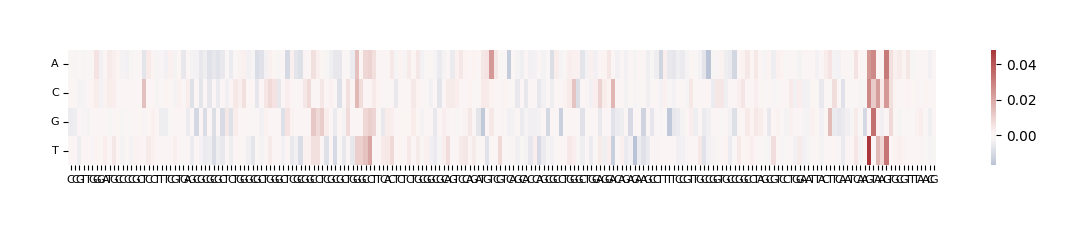

In [44]:
grelu.visualize.plot_ISM(ism, method="heatmap", figsize=(14, 1.5), center=0)

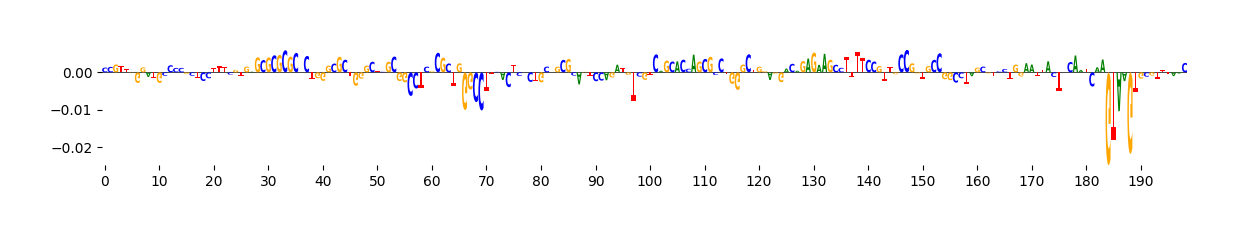

In [45]:
grelu.visualize.plot_ISM(ism, method="logo", figsize=(14, 1.5))

See the subsequent tutorials to learn about other things you can do with this model, including fine-tuning, variant effect prediction, and sequence design.